##**Import Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##**Load and Inspect Data**
####First, Load and inspect the dataset.

In [ ]:
import pandas as pd

# Load the dataset
file_path = '/content/drive/MyDrive/nlp-getting-started/train.csv'
data = pd.read_csv(file_path)

# Inspect the dataset
print(data.head())
print(data.info())


   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


##**Data Preprocessing**
####Clean the text by removing unwanted characters, links, and normalize it for BERT tokenization.

In [ ]:
import re
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer

# Function to clean the text data
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove links
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    text = text.lower().strip()  # Convert to lowercase
    return text

# Apply cleaning to the 'text' column
data['text'] = data['text'].apply(clean_text)

# Tokenize the data using BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenizing function
def tokenize(text):
    return tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors='pt')

# Splitting dataset into training and validation
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# Prepare input ids and attention masks
train_encodings = tokenizer(list(train_data['text']), padding=True, truncation=True, max_length=128, return_tensors='pt')
val_encodings = tokenizer(list(val_data['text']), padding=True, truncation=True, max_length=128, return_tensors='pt')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


EDA Exploratory Data Analysis

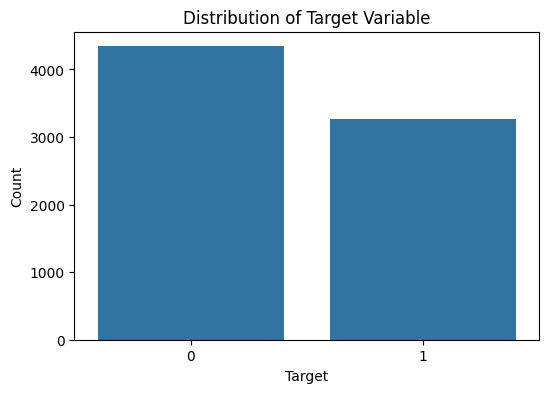

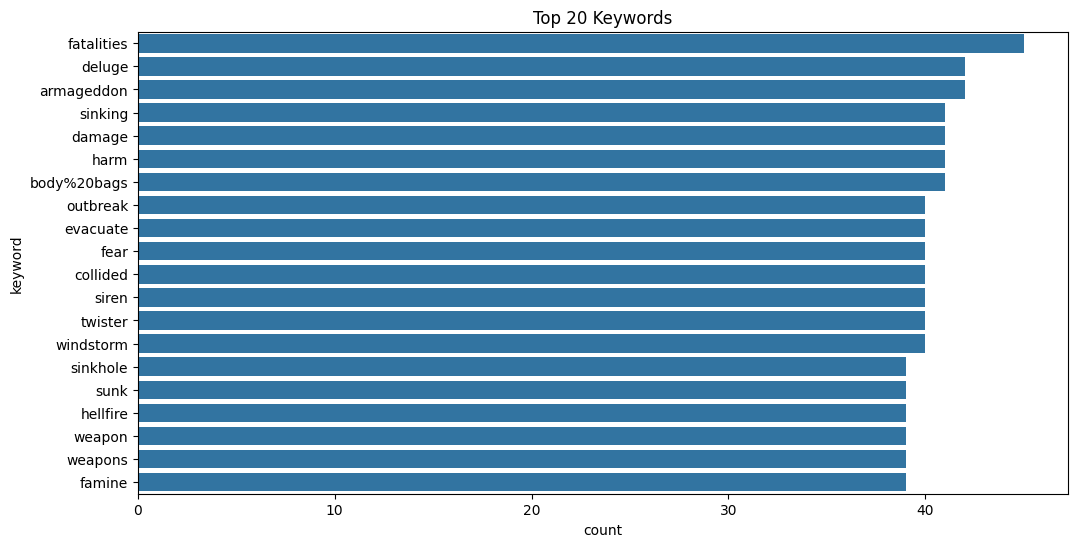

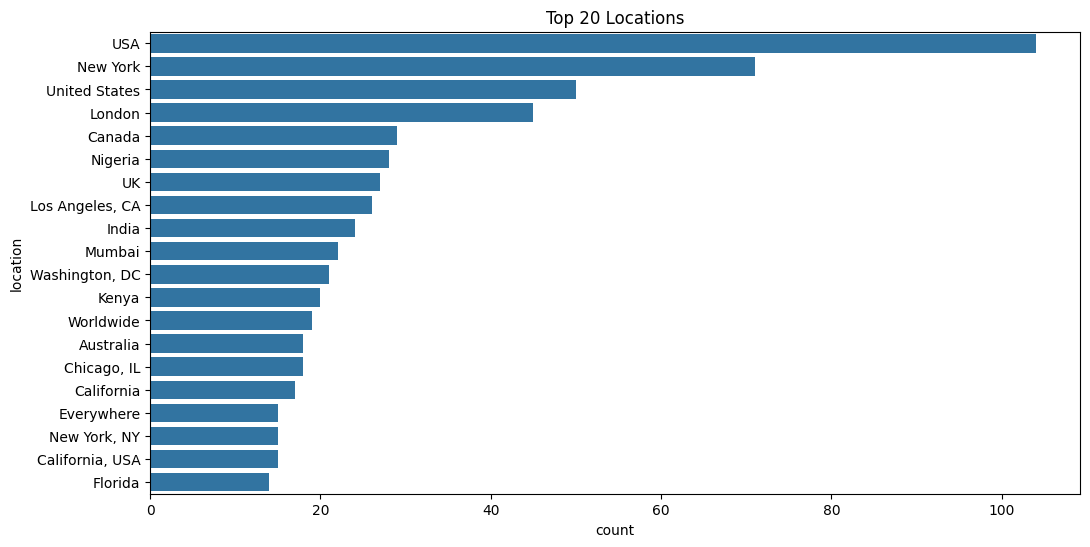

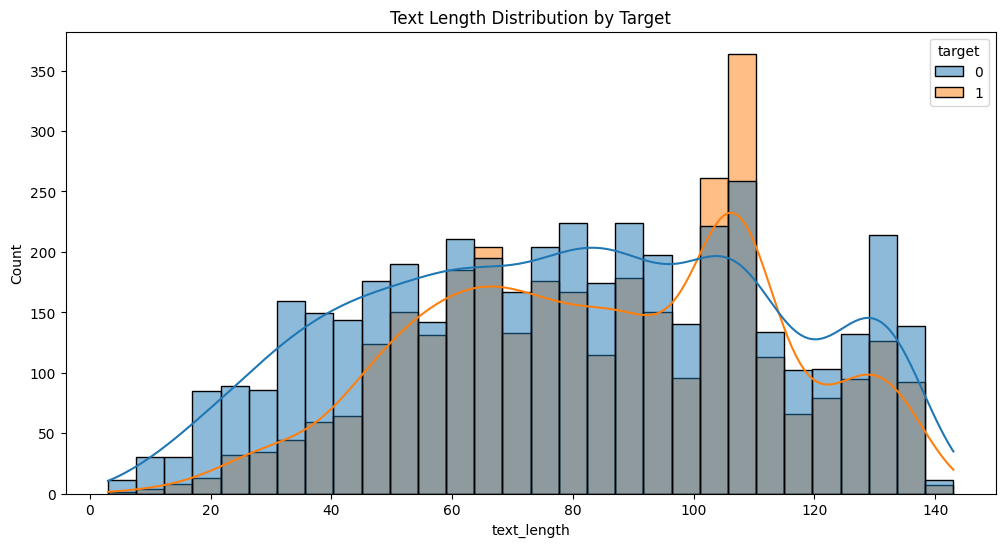

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# EDA

# Distribution of the target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=data)
plt.title('Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

# Keyword analysis
plt.figure(figsize=(12,6))
sns.countplot(y='keyword', data=data, order=data['keyword'].value_counts().iloc[:20].index)
plt.title('Top 20 Keywords')
plt.show()

# Location analysis
plt.figure(figsize=(12,6))
sns.countplot(y='location', data=data, order=data['location'].value_counts().iloc[:20].index)
plt.title('Top 20 Locations')
plt.show()

# Text length analysis
data['text_length'] = data['text'].apply(len)
plt.figure(figsize=(12,6))
sns.histplot(data=data, x='text_length', hue='target', bins=30, kde=True)
plt.title('Text Length Distribution by Target')
plt.show()

##**Model Creation**
####Use the Hugging Face transformers library to fine-tune a pre-trained BERT model.

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertForSequenceClassification, AdamW, get_scheduler
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from torch.nn import CrossEntropyLoss

class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}, self.labels[idx]

# Initialize the BERT model for classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Prepare datasets
train_dataset = TweetDataset(train_encodings, torch.tensor(train_data['target'].values))
val_dataset = TweetDataset(val_encodings, torch.tensor(val_data['target'].values))

# Calculate the class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_data['target']), y=train_data['target'])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Class weights for target = 0 (non-disaster) and target = 1 (disaster)
print("Class Weights:", class_weights)



# Modify the loss function to include class weights
loss_fn = CrossEntropyLoss(weight=class_weights)

# Define the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Class Weights: tensor([0.8780, 1.1613])


##**Training Loop**
####We will define the training loop with optimization and evaluation.

In [ ]:
from transformers import get_scheduler
from tqdm import tqdm
import torch
from torch.nn import CrossEntropyLoss
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

# Define training parameters
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# Learning rate scheduler
num_epochs = 3
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# Training loop
for epoch in range(num_epochs):
    model.train()
    for batch in tqdm(train_loader):
        inputs = {k: v.to(device) for k, v in batch[0].items()}
        labels = batch[1].to(device)
        outputs = model(**inputs, labels=labels)
        # loss = outputs.loss
        # loss.backward()
        logits = outputs.logits

        # Use custom loss function
        loss = loss_fn(logits, labels)
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

    # Evaluation loop
    model.eval()
    total_acc = 0
    total_count = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs = {k: v.to(device) for k, v in batch[0].items()}
            labels = batch[1].to(device)
            outputs = model(**inputs)
            predictions = torch.argmax(outputs.logits, dim=-1)
            total_acc += (predictions == labels).sum().item()
            total_count += labels.size(0)

    print(f"Epoch {epoch + 1}: Validation Accuracy = {total_acc / total_count}")

def evaluate_model(model, val_loader):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            inputs = {k: v.to(device) for k, v in batch[0].items()}
            labels = batch[1].to(device)
            outputs = model(**inputs)

            # Get the predicted class labels
            preds = torch.argmax(outputs.logits, dim=-1)

            # Append predictions and true labels for evaluation
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Generate the classification report
    report = classification_report(all_labels, all_preds, target_names=['non-disaster', 'disaster'], digits=4)
    print("Classification Report:\n", report)

    # Evaluate the model on the validation set after each epoch
    print(f"Epoch {epoch + 1} evaluation:")
    evaluate_model(model, val_loader)


100%|██████████| 381/381 [50:12<00:00,  7.91s/it]


Epoch 1: Validation Accuracy = 0.7898883782009193


100%|██████████| 381/381 [49:46<00:00,  7.84s/it]


Epoch 2: Validation Accuracy = 0.8063033486539725


100%|██████████| 381/381 [49:40<00:00,  7.82s/it]


Epoch 3: Validation Accuracy = 0.804333552199606


In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Function to evaluate a given threshold and return precision, recall, and F1-score
def evaluate_threshold(model, val_loader, threshold):
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            inputs = {k: v.to(device) for k, v in batch[0].items()}
            labels = batch[1].to(device)
            outputs = model(**inputs)

            probs = torch.softmax(outputs.logits, dim=-1)  # Get probabilities
            preds = (probs[:, 1] > threshold).long()  # Apply threshold

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute Precision, Recall, and F1-score for the current threshold
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
    return precision, recall, f1

# Function to perform grid search over a range of thresholds
def grid_search_thresholds(model, val_loader, thresholds):
    best_threshold = None
    best_f1 = 0
    results = []

    for threshold in thresholds:
        precision, recall, f1 = evaluate_threshold(model, val_loader, threshold)
        results.append((threshold, precision, recall, f1))

        if f1 > best_f1:  # Update if the current F1-score is better
            best_f1 = f1
            best_threshold = threshold

        print(f"Threshold: {threshold:.2f} | Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

    print(f"\nBest Threshold: {best_threshold:.2f} with F1: {best_f1:.4f}")
    return best_threshold, results

# Grid search over thresholds between 0.5 and 0.9
thresholds = [i/100 for i in range(50, 91, 5)]  # Values: [0.50, 0.55, ..., 0.90]
best_threshold, results = grid_search_thresholds(model, val_loader, thresholds)


Threshold: 0.50 | Precision: 0.7540, Recall: 0.8028, F1: 0.7776
Threshold: 0.55 | Precision: 0.7621, Recall: 0.7997, F1: 0.7805
Threshold: 0.60 | Precision: 0.7812, Recall: 0.7920, F1: 0.7865
Threshold: 0.65 | Precision: 0.7941, Recall: 0.7843, F1: 0.7891
Threshold: 0.70 | Precision: 0.8068, Recall: 0.7720, F1: 0.7890
Threshold: 0.75 | Precision: 0.8280, Recall: 0.7643, F1: 0.7949
Threshold: 0.80 | Precision: 0.8362, Recall: 0.7473, F1: 0.7893
Threshold: 0.85 | Precision: 0.8498, Recall: 0.7411, F1: 0.7918
Threshold: 0.90 | Precision: 0.8696, Recall: 0.7196, F1: 0.7875

Best Threshold: 0.75 with F1: 0.7949


##**Save and Load the Model**
####We will save the trained model and load it for inference.

In [ ]:
# Save the model
model.save_pretrained('./bert_disaster_tweet_model_1')

# Load the model for inference
model = BertForSequenceClassification.from_pretrained('./bert_disaster_tweet_model_1')
model.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

#**Model Testing and Evaluation Phase**

1.   Load and Inspect the Test Dataset







In [ ]:
# Load the test dataset
test_file_path = '/content/drive/MyDrive/nlp-getting-started/test.csv'
test_data = pd.read_csv(test_file_path)

# Inspect the test dataset
print(test_data.head())
print(test_data.info())


   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None


##**Preprocess the Test Data**
Clean and tokenize the test data just like we did with the training data.

In [ ]:
# Reuse the clean_text function from before
test_data['text'] = test_data['text'].apply(clean_text)

# Tokenize the test data
test_encodings = tokenizer(list(test_data['text']), padding=True, truncation=True, max_length=128, return_tensors='pt')


##**Load the Trained Model**
Load back the saved model that was trained.

In [ ]:
# Load the pre-trained model
model = BertForSequenceClassification.from_pretrained('./bert_disaster_tweet_model_1')

# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
model.eval()  # Set the model to evaluation mode


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

##**Predictions on the Test Data**
Iterate through the test data and make predictions using the trained model.

In [ ]:
from torch.utils.data import Dataset, DataLoader

# Create a Dataset class for the test data
class TweetTestDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}

# Create test dataset
test_dataset = TweetTestDataset(test_encodings)

# Create DataLoader for test dataset
test_loader = DataLoader(test_dataset, batch_size=16)

# Make predictions
predictions = []
with torch.no_grad():
    for batch in test_loader:
        inputs = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=-1)

        # Use the best threshold for classification
        preds = (probs[:, 1] > best_threshold).long()
        predictions.extend(preds.cpu().numpy())

# Add predictions to the test dataset and save to CSV
test_data['target'] = predictions
test_data[['id', 'target']].to_csv('submission.csv', index=False)
print(f"Predictions saved to 'submission.csv' using best threshold {best_threshold}")


Predictions saved to 'submission.csv' using best threshold 0.75


##**Save Predictions to CSV**
####We have the predictions, we'll save them to a CSV file for submission.

In [ ]:
# Save predictions in the required format (CSV)
# sample_submission["target"] = np.argmax(classifier.predict(X_test), axis=1)
test_data[['id', 'target']].to_csv('submission1.csv', index=False)

print("Predictions saved to 'submission1.csv'")
